# NLP (Natural Language Processing) avec TensorFlow !

## Détection du Sarcasme en language naturel :-)

Doc House : médecin héroique ou roi du sarcasme ?!

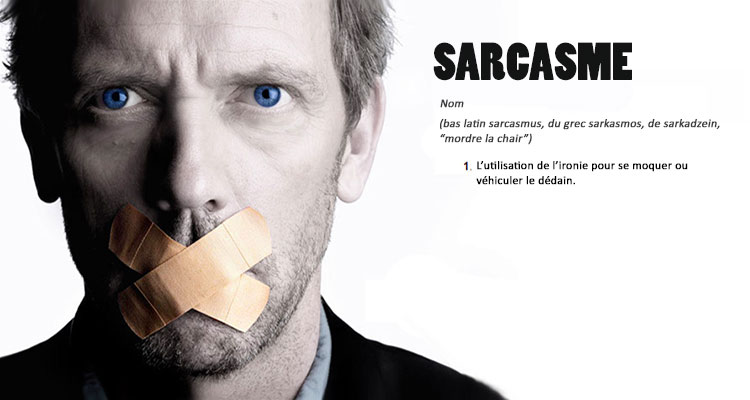

La **NLP** est la science du traitement du **language Naturel** .

C'est un domaine trés vaste de l'apprentissage automatique qui permet par exemple de classifier, déterminer les sentiments associés à des phrases, de générer du texte de façon automatiser (via les GAN) de créer des chatbots...

**Traitement du Language**

Le traitement du language diffère des autres domaines du machine/deep learning dans le sens ou il ne s'agit pas de traiter des matrices, des vecteurs ou des tenseurs mais des mots, phrases du langages humain. De ce fait, étant donné que les algorithmes ne savent traiter ques des nombres ou du moins des entrées normalisées il est nécessaire de passer par des étapes de transformation et de conversion que nous allons détailler. 
Par ailleurs, la difficulté de notre language et les subtilités syntaxiques rendent ce travail d'apprentissage une tâche ardue.

Il existe heuresement des bibliothèques et des algorithmes spécialisés permettant de répondre et adresser ce genre de problématique. Les librairies les plus connues étant Nltk, TensorFlow ou SpaCy... Dans les techniques que nous allons aborder on parlera également de Tokenisation, Lemmatization, Stemming et de Bag of words ...

Dans ce tutorial nous allons voir comment de façon très simple prédire à partir d'un jeu de données issues de titres de journées si les phrases en question sont sarcastiques ... ou non ! 

**Architecture du réseau de neurones**

Pour ce faire nous n'allons plus cette fois comme dans les réseaux de Convolution utiliser la même architecture de réseaux de neurones. En effet ces derniers n'avaient pas besoin de possèder de la mémoire pour travailler, chaque classification d'image pouvait se faire de façon indépendante.

Pour ce travail qui est d'une nature différente il est nécessaire d'utiliser un type de neurone permettant de conserver la mémoire des éléments vu précédement.
Nous allons pour ce faire utiliser un type de neurone appelé **LSTM** (Long Short Term Memory). 

En synthèse ce sont des neurones capables d'avoir une mémoire du passé des données déjà traitées. Cette caractéristique est essentielle puisque l'analyse du sens d'une phrase dépend des termes précédents.

**Le Sarcasme**

Le sarcasme désigne une moquerie ironique, une raillerie tournant en dérision une personne ou une situation. Il est mordant, souvent même amer et blessant. Il peut être considéré comme une forme d'ironie piquante ou belliqueuse.

> Le titre de philosophe sera à plus haut prix, on ne l'obtiendra pas en répétant les sophismes de J.-J. Rousseau (...) ou les sarcasmes de Voltaire

**A l'attaque !**

Je conseille avant l'étude ce tutorial de commencer par mes tutos sur la classification des images. En effet certains éléments déjà expliqués précédement ne seront pas forcement détaillés de nouveaux. Egalement, j'en profite pour introduire un concept Pythonique permettant de remplacer les horribles boucles for : il s'agit des 'list comprehension'. Je conseille au lecteur de ce pencher sur ce point car elles rendent de nombreux services tout en simplifiant le code :-)


### Références

Avant tout quelques références de liens ayant permis ce tutoriel ainsi que des lectures complémentaires pour approfondir le sujet.

http://cs229.stanford.edu/proj2015/044_report.pdf
https://github.com/lmoroney/dlaicourse/tree/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP
https://www.kaggle.com/nilanml/detecting-sarcasm-using-different-embeddings
https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection
https://www.kaggle.com/wflazuardy/sarcasm-detection-with-keras-preprocessing
https://www.kaggle.com/mytymohan/sarcasm-with-keras


### Configuration

Nous rassemblons les principaux éléments de configurations du programme dans le bloc ci-dessous que nous allons expliquer le moment venu. La configuration d'un seul bloc permet de simplifier la lecture du programme en rassemblant l'ensemble des variable à un seul endroit. Je conseille de rassembler toutes les variables permettant les configurations afin de simplifier les executions avec différents paramètres comme ci-dessous:

In [1]:
###########################
# Configuration Principale
# #########################

vocab_size= 22000        # Taille maximale du corpus de vocabulaire du jeu de données
embedding_dim=32         # Nombre d'embedding dimensions permettant de qualifier un mot
max_length = 18          # Longueur maximale en nombre de mots des titres avant de tronquer
trunc_type='post'        # Méthode pour trunquer si dépassement (avant ou après)
padding_type='post'      # Paramètre du padding (après la phrase)
oov_tok='<OOV>'          # Token à utiliser quand un mot est manquant
training_size=22000      # Taille du training Set (pour le split entre train/test)
num_epochs = 10          # Nombre epoch pour entrainement du réseau
DEL_STOPWORDS = False    # Pour la suppression des Stop Words
DO_LEMMATIZE  = True     # Lemmatization des mots
PATIENCE_STOPPING = 5    # Patience en nombre d'epoch avant de stopper l'entrainement
OPTIMIZER = 'adam'       # Optimizer pour la descente de gradient (optimisation fonction coût)

### Import des librairies / Datas

In [2]:
# Lib Standards
import os
import io

# Désactiver les avertissements
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# Verification de l'import des Data
print("Les données importées dans Kaggle: ")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Les données importées dans Kaggle: 
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [3]:
# Import des Librairies Datascience
import numpy as np 
import pandas as pd       
import random
import nltk

# Import TensorFlow et vérification de la version
import tensorflow as tf
print("Version de TensorFlow: {}".format(tf.__version__))
# Version majeure:
vers_tf = int((tf.__version__).split(sep='.')[0])

if vers_tf < 2:
    # eager_execution nécessaire si TensorFlow < 2.0
    print('Version < 2 : activation eager execution')
    tf.enable_eager_execution()

# Import des librairies de NLP
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Librairies nltk pour la tokenization et la Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

Version de TensorFlow: 1.14.0
Version < 2 : activation eager execution


### Affichage des Datas

Comme toujours nous commençons par importer les données grâce à la librairie Panda.
Ensuite nous allons regarder comment elles se composent.

In [4]:
# Toujours frâce à la librairie Panda nous procédons à l'ouverture du fichier de data
# Ouverture du fichier de données contenant les titres
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)

# Pour voir le nom des colonnes et la taille des objects du dataset importé
# Objet dataframe, nous observons grâce à cette sortie : 
#     Les colonnes du DataFrame
#     leur Type
#     Le nombre d'enregistrements
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
article_link    26709 non-null object
headline        26709 non-null object
is_sarcastic    26709 non-null int64
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [5]:
# On examine les premières lignes du dataset
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Ci-dessus nous observons que le jeu de données contient les liens des articles, les titres, et le label. 

**Les données sont labellisées** : 0 signifie que le titre n'est pas sarcastique et 1 qu'il l'est.

Nous allons donc maintenant dénombrer la répartition de ces deux catégories:

In [6]:
# denombrage du nombre articles classifié sarcastic et des autres 
nb_sarcastic = (df['is_sarcastic'] == 1).sum()
nb_not_sarcastic = (df['is_sarcastic'] == 0).sum()
print("Il y a {} titres sarcastiques vs {} qui ne le sont pas".format(nb_sarcastic, nb_not_sarcastic))

Il y a 11724 titres sarcastiques vs 14985 qui ne le sont pas


Nous observons ci-dessus que le jeu de données n'est pas réparti à 50% entre les données sarcastiques et les autres.
Cependant nous ne risquons pas dans ce cas de figure d'entrainer un biais lors de l'apprentissage ce qui pourrait se produire si jamais les éléments positif était trés rare. 

=> **Les classes à prédire n'étant pas unbalanced nous ne feront donc pas de traitement particulier sur ce point**

In [7]:
# Affichage au hasard de quelques titres et de leur label
for i in range(3):
    n = random.randrange(len(df['headline']))
    print(df['article_link'][n])
    print(df['headline'][n])
    print("Sarcasme: {}".format(df['is_sarcastic'][n]))
    print("---")

https://entertainment.theonion.com/new-archie-graphic-novel-explores-rich-inner-life-of-ju-1819568903
new archie graphic novel explores rich inner life of jughead
Sarcasme: 1
---
https://www.huffingtonpost.com/entry/apple-watch-apps_n_7127394.html
not sure what an apple watch is for? try these 12 apps
Sarcasme: 0
---
https://www.huffingtonpost.com/entry/utah-adopts-stricter-drunk-driving-law-us_us_58d4220de4b02d33b749d400
utah adopts nation's strictest drunk driving law
Sarcasme: 0
---


Maintenant construisons notre jeu de données avec les phrases (X) et leurs label (y)

**Pour respecter les conventions usuelles nous les nommerons X et y**

In [8]:
# Contruction des listes de phrases(X) et de labels(y)
X=list(df['headline'])
y=list(df['is_sarcastic'])

### Suppression des Stopwords (optionnel)

Cette étape permet de supprimer les stopwords Les stopwords sont les mots de language n'apportant pas de valeurs dans l'analyse de la phrase.
En anglais ce sont par exemple des termes comme : 'in', 'the', 'a', 'of' ...

Bien que ceux-ci puissent avoir une imporance dans l'analyse d'une phrase, leur suppression permet également de diminuer le corpus de vocabulaire et donc de gagner un précieux temps de traitement. Tout dépend donc du besoin et du jeu de données en entrée.

Néamoins voici une façon de **supprimer les stopwords avec NLTK** avec au passage l'utilisation de **list comprehension en Python** :

In [9]:
# Import des stopwords grace à nltk
stopwords = nltk.corpus.stopwords.words('english')
print("Nous avons {} stopwords pour le language anglais. Exemple:".format(len(stopwords)))
print(stopwords[0:50])

Nous avons 179 stopwords pour le language anglais. Exemple:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be']


In [10]:
# Fonction pour gérer la suppression des stopwords
def process_stop_words(X, display_res=True):
    
    if DEL_STOPWORDS:
        # Une autre façon de Tokeniser:
        # avec fonctions lambda + fonction map
        # tokenize = lambda x: text_to_word_sequence(x, 
        #                                    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
        #                                    lower=True, split=' ')
        # X_seq = list(map(tokenize, X))
        
        # avec la liste comprehension et la librairie NLTK:
        X_seq = [[word for word in word_tokenize(s)] for s in X]
        
        # Suppression des Stopwords 
        X_seq_no_stops = [[word for word in s if word not in stopwords] for s in X_seq]
        
        if display_res:
            print("Avant Tokenization:     {}".format(X[10]))
            print("Après Tokenization:     {}".format(X_seq[10]))
            print("Sans Stopwords:         {}".format(X_seq_no_stops[10]))
        return X_seq_no_stops
    else:
        print("Pas de traitement stopwords")
        return X

In [11]:
# ---------------------------------------------------
# Gain apporté par les 'list comprehension' de Python
# ---------------------------------------------------

# Grâce a une seule ligne ci-dessous...
#[[word for word in s if word not in stopwords] for s in X_seq]

# ...factoriser le code suivant:

# X_no_stops = [[0] * 0 for i in range(len(X))]
# for n,title in enumerate(X):
#    for word in title:
#        if word not in stopwords:
#           X_no_stops[n].append(word)

In [12]:
# Processing des Stop Words
X = process_stop_words(X)

Pas de traitement stopwords


### Lemmatization (Optionnel)

Définition : 
La lemmatisation en linguistique consiste à regrouper les formes infléchies d'un mot afin qu'elles puissent être analysées comme un élément unique, identifié par le lemme du mot ou la forme du dictionnaire. Contrairement à un radical, la lemmatisation du jeu de données vise à réduire les mots en fonction d’un dictionnaire ou d’un vocabulaire réel (le lemma).

De même que pour la suppression des stop words la Lemmatization peut être appliquée ou non en fonction du jeu de données à traiter.

Exemple et mise en oeuvre ci-dessous:

In [13]:
print("Exemple de Lemme:")
list_lemm_exemple = ['cars', 'tools', 'airplane', 'nicely', 'sarcastic']
for w in list_lemm_exemple:
    print("    {}   =>   {}".format(w, WordNetLemmatizer().lemmatize(w)))

Exemple de Lemme:
    cars   =>   car
    tools   =>   tool
    airplane   =>   airplane
    nicely   =>   nicely
    sarcastic   =>   sarcastic


In [14]:
def process_lemmatization(X, display_res=True):
    if DO_LEMMATIZE:
        lemm = WordNetLemmatizer()
        if display_res:
            print("Avant Lemmatization :    {}".format(X[10]))
        Xlem = X.copy()

        # Si nous avons une liste de liste 
        # suite à la tokenization des titres pour suppression des stopword
        
        if DEL_STOPWORDS:
            # Ancienne méthode avec parcourt de liste
            # for row,title in enumerate(X):
            #    for col,word in enumerate(title):
            #        Xlem[row][col] = lemm.lemmatize(word)
            
            # Plus simple Avec les génerateurs de liste :-)
            Xlem = [[lemm.lemmatize(word) for word in s] for s in X]

        # une liste de titre
        else:
            Xlem = [[lemm.lemmatize(word) for word in word_tokenize(s)] for s in X]

        if display_res:
            print("Apres Lemmatization :    {}".format(Xlem[10]))

        return Xlem
    else:
        print("Pas de lemmatization demandée")
        return X

In [15]:
# Traitement de la lemmatization
X = process_lemmatization(X)

Avant Lemmatization :    airline passengers tackle man who rushes cockpit in bomb threat
Apres Lemmatization :    ['airline', 'passenger', 'tackle', 'man', 'who', 'rush', 'cockpit', 'in', 'bomb', 'threat']


### Split Train / Test

Nous splittons les jeux de données entre le jeu d'entrainement sur lequel le réseau de neurone va faire l'apprentissage et le jeu de test utilisé pour vérifier la conformité des prédictions.

In [16]:
# Constitution des jeux d'entrainements et de test
X_train = X[:training_size]
y_train = y[:training_size]
X_test  = X[training_size:]
y_test  = y[training_size:]

print("Taille jeu d'entrainement : {}".format(len(X_train)))
print("Taille jeu de test : {}".format(len(X_test)))

Taille jeu d'entrainement : 22000
Taille jeu de test : 4709


### Tokenisation / Séquences

Pour cette étape de processing qui est une des plus importante notre objectif est de convertir chaque ligne de texte des titres en séquences d'entier.

Pour ce traitement nous utilisons l'objet **Tokenizer de tensorflow**.

Voici le lien vers la documentation : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer


NB: pour la méthode fit_on_texts La documentation stipule : 

*Updates internal vocabulary based on a list of texts.
In the case where texts contains lists, we assume each entry of the lists to be a token.*

**Ainsi nous pouvons travailler avec des listes de phrases ou des listes de tokens**


Nous commençons par initialiser l'objet Tokenizer avec nos paramètres, puis nous l'entrainons sur le jeu d'entrainement (X_train).

Ensuite nous formons des séquences d'entier auxquelles nous ajoutons un padding afin d'avoir des longueurs constantes pour l'entrainement du réseau de neurones

In [17]:
# Instanciation du Tokenizer avec les paramètres
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
# Adaptation du Tokenizer au jeu d'entrainement
tokenizer.fit_on_texts(X_train)
# Création d'un dictionnaire d'index des mots
word_index = tokenizer.word_index                             

# Conversion en sequences d'entier
X_train_sequences = tokenizer.texts_to_sequences(X_train)

# Ajout du padding 
# Objectif: permettre à chaque séquence de possèder la même longueur
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, truncating = trunc_type)

In [18]:
# Traitement du jeu de test à l'identique du jeu d'entrainement
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_length, truncating = trunc_type)

In [19]:
# Nombre de mot dans le corpus
print("Nombre de mot dans le corpus du jeu d'entrainement : {}".format(len(word_index)))

Nombre de mot dans le corpus du jeu d'entrainement : 23839


In [20]:
# Création d'un index inversé des mots / digit associé
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Affichage de quelques phrases aléatoires:
for i in range(3):
    alea = random.randrange(len(X_train))
    print("phrase originale: {}".format(X_train[alea]))
    print("sequence : {}".format(X_train_sequences[alea]))
    print("sequence + bourrage: {}".format(X_train_padded[alea]))
    print("reconstitution: {}".format(decode_review(X_train_padded[alea])))
    print("----------------------------------------------------------------------")

phrase originale: ['trumpcare', 'scored', 'so', 'badly', 'it', 'could', 'actually', 'help', 'the', 'senate']
sequence : [3621, 11212, 150, 4614, 21, 95, 234, 212, 4, 273]
sequence + bourrage: [    0     0     0     0     0     0     0     0  3621 11212   150  4614
    21    95   234   212     4   273]
reconstitution: ? ? ? ? ? ? ? ? trumpcare scored so badly it could actually help the senate
----------------------------------------------------------------------
phrase originale: ['donald', 'trump', 'name', 'rex', 'tillerson', 'secretary', 'of', 'state']
sequence : [62, 16, 243, 3003, 3004, 555, 3, 103]
sequence + bourrage: [   0    0    0    0    0    0    0    0    0    0   62   16  243 3003
 3004  555    3  103]
reconstitution: ? ? ? ? ? ? ? ? ? ? donald trump name rex tillerson secretary of state
----------------------------------------------------------------------
phrase originale: ['trump', 'aim', 'to', 'limit', 'the', 'education', 'department', "'s", 'influence', 'in', 'new', 'o

### Création du Réseau neuronal réccurent

Un réseau RNN (Réseau de neurones récurrents) permet de souvenir de choses importantes concernant les données du passées qu'ils ont reçues.

Cette caractéristique leur permet de traiter des données séquentielles comme les séries temporelles, la parole, le texte, les données financières... Ils permettent d'avoir compréhension profonde d'une séquence et de son contexte associé.

Il existe plusieurs type de RNN tel que les GRU et les LSTM qui ont des architectures internes différentes.

Pour implémenter notre réseau nous allons utiliser le LSTM.


#### Neurone de type LSTM

Le LSTM (Long Short Term Memory) est un type de neurone permettant la mémorisation des informations passées (Long termet et court terme)

Ce type de neurone trop complexe peut être étudié dans ce tutorial permet via des méchanismes internes la mémorisation et/ou l'oubli de certaines informations selon des critères particuliers. Dans le shéma ci-dessous, la ligne du dessus réprésente la mémoire interne du neurones, les autres sont des portes pour entrées des nouvelles données ou sortir des données existantes (avec des coefficients).

C'est un élément clé du Deep Leaning moderne (exemple dans le prédictions de séquences / détéction d'anomalie)

Pour une explication détaillée du dessous de la scène : 
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ et https://hackernoon.com/understanding-architecture-of-lstm-cell-from-scratch-with-code-8da40f0b71f4

Ci dessous un exemple de traitement des informations temporelle : un RNN peut être vu comme une séquence de réseaux neuronaux.

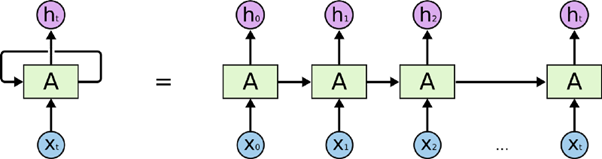

Grâce aux librairies de TensorFlow nous allons construire un type de réseau en stackant plusieurs couches de LSTM et toute simplicité

**Structure interne d'un LSTM** 

la ligne du dessus est la mémoire qui se propage de cellule en cellule , les autres lignes sont des portes de mémorisation (i: input) ou d'oubli (f: forget).
On voit sur le schéma plusieur entrées qui représentent:  l'entrée de l'information courante,  l'information du timestep précédent et la ligne de mémoire qui contient ce qu'il a appris des entrées du passé.
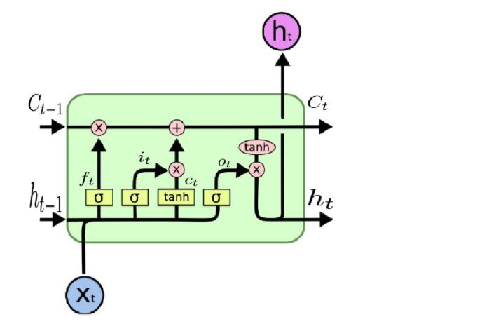

### Construction du Réseau

Il est temps maintenant de passer à l'étape de construction !

In [21]:
# Création du réseau neuronal avec LSTM
model = tf.keras.Sequential([
    
    ### Couche d'entrée
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    
    ### Couche des LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    
    ### Couche de neurones connectés
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    ### Couche de Sortie
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 32)            704000    
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 64)            16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0

Il est à noter ici que nous construisons un **LSTM bidirectionnel** ce qui signifie que les entrées seront lues dans les deux sens permettant de conserver dans deux états mémoire différents les informations du passé et celles du futures ! Dans notre cas de figure pour la compréhension du sens d'une phrase il est important d'avoir les informations du passé mais aussi celles du future afin de mieux maitriser le contexte.

Vous pouvez de fait voir dans le summary() du réseau que la couche de LSTM à 2x plus de paramètres que ce que nous avons défini dans le code.

In [22]:
# Callbacks (Expliqué dans les tutoriaux CNN)
checkpoint = ModelCheckpoint("model_sarcasm.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE_STOPPING, verbose=1, mode='auto')

In [23]:
### Entrainement du modèle
# NB : il est possible d'inclure le paramètre validation_split dans fit() 
# afin de ne pas traiter le split train/test plus tôt

history=model.fit(X_train_padded,
                  y_train,
                  epochs=num_epochs,
                  validation_data=(X_test_padded, y_test),
                  callbacks = [checkpoint, early],
                  verbose=1)

Train on 22000 samples, validate on 4709 samples
Epoch 1/10
21984/22000 [============================>.] - ETA: 0s - loss: 0.4677 - acc: 0.7801
Epoch 00001: val_loss improved from inf to 0.34325, saving model to model_sarcasm.h5
22000/22000 [==============================] - 70s 3ms/sample - loss: 0.4676 - acc: 0.7801 - val_loss: 0.3432 - val_acc: 0.8579
Epoch 2/10
21984/22000 [============================>.] - ETA: 0s - loss: 0.2412 - acc: 0.9163
Epoch 00002: val_loss did not improve from 0.34325
22000/22000 [==============================] - 54s 2ms/sample - loss: 0.2414 - acc: 0.9162 - val_loss: 0.3512 - val_acc: 0.8622
Epoch 3/10
21984/22000 [============================>.] - ETA: 0s - loss: 0.1367 - acc: 0.9556
Epoch 00003: val_loss did not improve from 0.34325
22000/22000 [==============================] - 55s 2ms/sample - loss: 0.1367 - acc: 0.9555 - val_loss: 0.4319 - val_acc: 0.8592
Epoch 4/10
21984/22000 [============================>.] - ETA: 0s - loss: 0.0794 - acc: 0.9761


### Graphing de l'entrainement

Pour comprendre comment le réseau apprend une bonne pratique et de procéder au graphing des données comme nous allons le réaliser ci-dessous:

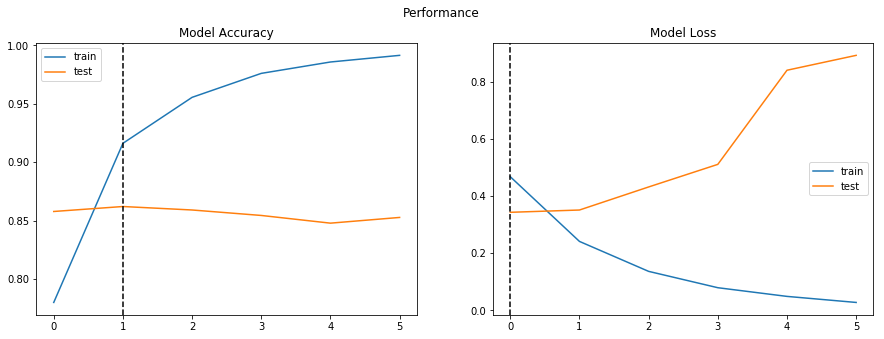

In [24]:
# Graphing de l'apprentissage

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
vline_cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

Nous observons avec les graphs qu'après 2 epochs la précision sur le jeu de test diminue.

### Prédictions sur deux exemples

Les graphs ci-dessus montrent une précisons sur le jeu de test entre 80% et 85% de la détection du sarcasme dans les phrases.

Faisons maintenant une prédiction sur deux nouvelles phrases:

In [25]:
# Test sur deux phrases de présence ou nom de saracasme
sentence = ["granny starting to fear spiders in the garden might be real!", "Doctor House season finale this sunday evening on TV."]
sentence = process_stop_words(sentence, display_res=False)
sentence = process_lemmatization(sentence, display_res=False)

Pas de traitement stopwords


In [26]:
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("Probabilité de détection du sarcasme: \n")
print(sentence)
print(model.predict(padded))

Probabilité de détection du sarcasme: 

[['granny', 'starting', 'to', 'fear', 'spider', 'in', 'the', 'garden', 'might', 'be', 'real', '!'], ['Doctor', 'House', 'season', 'finale', 'this', 'sunday', 'evening', 'on', 'TV', '.']]
[[0.88196313]
 [0.00787356]]


Nous voyons ci-dessus au niveau des probabilités de sortie que le modèle classifie la première phrase comme étant un sarcasme et la deuxième ne l'étant pas. On peut donc dire que c'est un succès à ce niveau, cependant il y a des choses qui restent a améliorer: en particulier je remarque qu'il semble y avoir un overfitting qui est difficile à faire disparaitre. Deuxiemement j'observe que la Lemmatization et la suppression des Stopwords semblent apporter une instabilité du modèle.

### Possibilités d'Optimisations pour aller plus loin
* Essayer de limiter l'overfitting constaté (avec dropout par exemple ou augmenter la taille du jeu d'entrainement)
* Tester différents type de réseaux et de neurones (exemple avec les GRU)
* Tester les différentes combinaisons de traitement (Lemmatization / Stopwords)
* Jouer avec les paramètres embedding_dimensions / vocab_size / taille des phrases maximums
* Modifier les paramètres des LSTM (nombre / stacking), modifier les paramètres de Dropout
* Tester différents optimizers et learning rates
* Disposer de jeux de données plus large et tester avec d'autres jeux de données
* Prendre en compte dans le modèle la source (url) et éventuellement l'article